<a href="https://colab.research.google.com/github/4en1x/diploma/blob/master/Final4NormsForChaotic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+git://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin
!cd /usr/src
!ln -sfn linux-headers-2.6.35-28-generic linux

  Cloning git://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-b5w4p2gb
  Stored in directory: /tmp/pip-ephem-wheel-cache-d4jl7hcg/wheels/10/c2/05/ca241da37bff77d60d31a9174f988109c61ba989e4d4650516
Successfully built NVCCPlugin
directory /content/src already exists
Out bin /content/result.out


In [6]:
%%cu
#include <cuda_runtime.h>
#include "device_launch_parameters.h"
#include <stdlib.h>
#include <stdio.h>
#include <float.h>
#include "linux/kernel.h"
#include <iostream>
#include <ctime>
#include <iomanip>
#include <fstream>
#include <math.h>
#include <cmath>

using namespace std;

#define ITERATIONS 1000000
#define N 1024

#define e 2.7182818

#define blockZSize 1

#define blockXSize 64
#define blockYSize 64

#define tileXSize 16
#define tileYSize 16

#define extN (N + 2)
#define Dx 1
#define h ((float) Dx / (N + 1))
#define h2 powf(h, 2.0)

__device__
float f(int i, int j) {
	return 2 * powf(e, i * h + j * h);
}

float u_t(float x) {
	return powf(e, x);
}

float u_l(float x) {
	return powf(e, x);
}

float u_r(float x) {
	return powf(e, x + 1);
}

float u_d(float x) {
	return powf(e, x + 1);
}


__device__
void tile(float* matrix, int iGl, int jGl, bool isBlack) {
	int iBegin = iGl * blockXSize + threadIdx.x * tileXSize + 1;
	int jBegin = jGl * blockYSize + threadIdx.y * tileYSize + 1;

  int N1 = tileXSize + blockZSize * 2;
  int N2 = tileYSize + blockZSize * 2;
  
	float helper[18 * 18];

  for(int i = 0; i < N1; i++) {
		for(int j = 0; j < N2; j++) {
      int dAI = iBegin - blockZSize + i;
      int dAJ = jBegin - blockZSize + j;
      if(dAI < 0 || dAI >= extN || dAJ < 0 || dAJ >= extN) {
          helper[i * N1 + j] = FLT_MAX;
      }
      else {
          helper[i * N1 + j] = matrix[extN * dAI + dAJ];
      }
		}
	}
  
  int iSplit = iBegin - blockZSize;
  int jSplit = jBegin - blockZSize;
    
  for(int k = 1; k < blockZSize; k++) {
		for (int i = k; i < N1 - k; i++) {
		  for (int j = k; j < N2 - k; j += 1) {
        int b = N1 * i + j;
        if(helper[b + N1] != FLT_MAX && helper[b - N1] != FLT_MAX && helper[b + 1] != FLT_MAX && helper[b - 1] != FLT_MAX) {
            helper[b] = 0.25 * (
                helper[b + N1]
              + helper[b - N1]
              + helper[b + 1]
              + helper[b - 1] 
              - h2 * f(iSplit + i, jSplit + j)
            );
        }
		  }
	  }
	}

  //printf("iGl : %d, %d, %d, %d, %d, %d, %d \n", iGl, jGl, threadIdx.x, threadIdx.y, isBlack, iBegin, jBegin);
    
  for (int i = iBegin; i < iBegin + tileXSize; i++) {
		for (int j = jBegin; j < jBegin + tileYSize; j += 1) {
      int helperIndex = N1 * (i - iBegin + blockZSize) + j - jBegin + blockZSize;
			matrix[extN * i + j] = 0.25 * (
          helper[helperIndex + N1]
        + helper[helperIndex - N1]
        + helper[helperIndex + 1]
				+ helper[helperIndex - 1] 
        - h2 * f(i - blockZSize + 1, j - blockZSize + 1)
      );
      helper[helperIndex] =	matrix[extN * i + j];
		}
	}
    
}

__global__
void calculateBlack(float* matrix) {
	tile(matrix, blockIdx.x, blockIdx.y, true);
}

__global__
void calculateRed(float* matrix) {
	tile(matrix, blockIdx.x, blockIdx.y, false);
}

float func(int i, int j) {
	return powf(e, i * h + j * h);
}

float* createMatrix(int row, int col) {
	float* matrix = new float[row * col];

	for(int i = 0; i < row; i++) {
		for(int j = 0; j < col; j++) {
			matrix[i * row + j] = 0;
		}
	}

  for(int i = 0; i < row; i++) {
      matrix[0 * row + i] = u_t((i) * h);
      matrix[(row - 1) * row + i] = u_d((i) * h);
  }

  for(int j = 0; j < col; j++) {
      matrix[j * col + 0] = u_l((j) * h);
      matrix[j * col + row - 1] = u_r((j) * h);
	}
    
	return matrix;
}

float calculateDifference(float* matrix1) {
	float tolerance = 0.0f;

  for (int i = 1; i < extN - 1; i++) {
		for (int j = 1; j < extN - 1; j++) {
      float fCurrent = func(i, j);
      tolerance += (matrix1[i * extN + j] - fCurrent) * (matrix1[i * extN + j] - fCurrent);
		}
	}

	return tolerance;
}

int main() {
    ofstream myfile;
  myfile.open("diff_4.txt");
	float* matrixHost = createMatrix(extN, extN);
	float* matrixDevice;

	int matrixSize = sizeof(float) * extN * extN;

	cudaMalloc((void**)&matrixDevice, matrixSize);
	cudaMemcpy(matrixDevice, matrixHost, matrixSize, cudaMemcpyHostToDevice);

	long startTime = clock();
	dim3 blocks(N / blockXSize, N / blockYSize);
	dim3 threads(blockXSize / tileXSize, blockYSize / tileYSize);

	for (size_t i = 0; i < ITERATIONS; i++) {
		calculateBlack <<< blocks, threads >>>(matrixDevice);
		cudaDeviceSynchronize();
		cudaPeekAtLastError();

    if(i%1000 == 0) {
        cudaMemcpy(matrixHost, matrixDevice, matrixSize, cudaMemcpyDeviceToHost);
        float diff = calculateDifference(matrixHost);
        cout << " Difference: " << diff << "iter: " << i;
        myfile << diff << " ";
    }  
	}

	std::cout << "Calculation take time: " << clock() - startTime << std::endl;
  cout << " Difference: " << calculateDifference(matrixHost);
	cudaError_t cudaResult = cudaMemcpy(matrixHost, matrixDevice, matrixSize, cudaMemcpyDeviceToHost);

	if (cudaResult != cudaSuccess) {
		std::cout << "Cuda error: " << cudaResult << std::endl;
	}

    myfile.close();
	return 0;
}

' Difference: 1.06622e+07iter: 0 Difference: 8.96337e+06iter: 1000 Difference: 8.30467e+06iter: 2000 Difference: 7.82563e+06iter: 3000 Difference: 7.43867e+06iter: 4000 Difference: 7.11008e+06iter: 5000 Difference: 6.82309e+06iter: 6000 Difference: 6.56668e+06iter: 7000 Difference: 6.33482e+06iter: 8000 Difference: 6.12249e+06iter: 9000 Difference: 5.92668e+06iter: 10000 Difference: 5.74467e+06iter: 11000 Difference: 5.57475e+06iter: 12000 Difference: 5.41506e+06iter: 13000 Difference: 5.26484e+06iter: 14000 Difference: 5.12241e+06iter: 15000 Difference: 4.98747e+06iter: 16000 Difference: 4.85912e+06iter: 17000 Difference: 4.73671e+06iter: 18000 Difference: 4.61978e+06iter: 19000 Difference: 4.5078e+06iter: 20000 Difference: 4.4004e+06iter: 21000 Difference: 4.29734e+06iter: 22000 Difference: 4.19828e+06iter: 23000 Difference: 4.1036e+06iter: 24000 Difference: 4.01142e+06iter: 25000 Difference: 3.92242e+06iter: 26000 Difference: 3.83646e+06iter: 27000 Difference: 3.75333e+06iter: 28000

Text(0, 0.5, 'Норма матрицы')

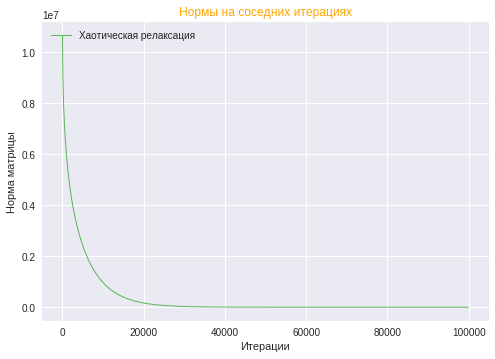

In [9]:
# libraries and data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os


k = 0

c1 = list(map(lambda x: float(x), open("diff1.txt", 'r').read().split(' ')[:-1]))[k:]
l = len(c1)



iterations = list(map(lambda x: x * 100,list(range(k,l + k))))

# style
plt.style.use('seaborn-darkgrid')
 
# create a color palette
palette = plt.get_cmap('Set1')
 
# multiple line plot 
plt.plot(iterations, c1,  marker='', color=palette(2), linewidth=1, alpha=0.9, label='Хаотическая релаксация')

# Add legend
plt.legend(loc=2, ncol=2)
 
# Add titles
plt.title("Нормы на соседних итерациях", loc='center', fontsize=12, fontweight=0, color='orange')
plt.xlabel("Итерации")
plt.ylabel("Норма матрицы")